In [13]:
# Import packages - may take a few seconds to load everything in
using Revise
using HistoryStacks
using LinearAlgebra
using OrdinaryDiffEq
using RecursiveArrayTools
using ForwardDiff
using Plots
default(grid=false,framestyle=:box,fontfamily="Computer Modern",label="",lw=2,palette=:tab10,labelfontsize=16, tickfontsize=12,legendfontsize=12,legend_background_color=nothing,legend_foreground_color=nothing)

In [14]:
# Planar double integrator with uncertain friction effects
f(x) = [x[3], x[4], 0.0, 0.0]
g(x) = vcat(zeros(2,2), diagm(ones(2)))
φ(x) = [-x[3] -abs(x[3])*x[3] 0.0 0.0;
        0.0 0.0 -x[4] -abs(x[4])*x[4]]
F(x) = g(x)*φ(x)
θ = [0.3, 0.1, 0.4, 0.2]
f(x, u) = f(x) + F(x)*θ + g(x)*u

f (generic function with 2 methods)

In [15]:
# Bounds on different parameters
θ1b = [0.0, 0.7]
θ2b = [0.0, 0.5]
θ3b = [0.0, 0.9]
θ4b = [0.0, 0.4]
𝚯 = [θ1b, θ2b, θ3b, θ4b]

4-element Vector{Vector{Float64}}:
 [0.0, 0.7]
 [0.0, 0.5]
 [0.0, 0.9]
 [0.0, 0.4]

In [16]:
# Obstacles and barrier function
xo = [-1.0, 1.0]
ro = 0.6
c(x) = norm(x[1:2] - xo) - ro^2
∇c(x) = ForwardDiff.gradient(c, x)
h(x) = ∇c(x)'f(x) + c(x)
∇h(x) = ForwardDiff.gradient(h, x)
Lfh(x) = ∇h(x)'f(x)
LFh(x) = ∇h(x)'F(x)
Lgh(x) = ∇h(x)'g(x)

Lgh (generic function with 1 method)

In [17]:
# Nominal PD controller 
Kp = 1.0
Kd = 0.5
k0(x) = -Kp*x[1:2] - Kd*x[3:4]

k0 (generic function with 1 method)

In [18]:
# Adaptive CBF safety filter
α(s) = s
ψ(x, θ̂, ϑ̃) = Lfh(x) + LFh(x)*θ̂ + Lgh(x)*k0(x) + α(h(x)) - norm(LFh(x))*ϑ̃
function kCBF(x, θ̂, ϑ̃)
    if ψ(x, θ̂, ϑ̃) >= 0.0 
        return k0(x)
    else
        return k0(x) - ψ(x, θ̂, ϑ̃)*Lgh(x)'/(Lgh(x)*Lgh(x)')
    end
end

kCBF (generic function with 1 method)

In [19]:
# Build odefuncion
function odefun(dy, y, p, t)
    # Unpack states
    x = y.x[1]
    θ̂ = y.x[2]
    ϑ̃ = y.x[3][1]

    # Unpack parameters
    H, γc = p["H"], p["γ"]

    # Assign vector fields
    dy.x[1] .= f(x, kCBF(x, θ̂, ϑ̃))
    dy.x[2] .= γc*gradient_vector_field(H, θ̂)
    dy.x[3] .= [upper_bound_update(H, ϑ̃, γc)]
end

odefun (generic function with 1 method)

In [20]:
# Define callback function for updating history stack

dt = 0.1 # How often we want to update stack
T = 20.0 # Length of sim
tstops = 0.0:dt:T # Stopping times

# Condition for stopping integrator
condition(u,t,integrator) = t ∈ tstops 

# Modify history stack when integration is stopped
function affect!(integrator)
    # Get states
    x = integrator.u.x[1]
    θ̂ = integrator.u.x[2]
    ϑ̃ = integrator.u.x[3][1]

    # Compute control
    u = kCBF(x, θ̂, ϑ̃)

    # Get regressor and target
    regressor = F(x)
    target = f(x, u) - f(x) - g(x)*u # Add noise here if desired

    # Update stack
    update!(integrator.p["H"], regressor, target)

    return integrator
end

# Create callback
cb = DiscreteCallback(condition, affect!)

DiscreteCallback{…}(condition, affect!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, Bool[1, 1])

In [21]:
# Initial conditions
x0 = [-2.1, 2.0, 0.0, 0.0]
θ̂0 = 0.1*ones(4)
ϑ̃0 = [worst_case_error(𝚯)]
y0 = ArrayPartition(x0, θ̂0, ϑ̃0)

# Learning gains
γc = 5.0

# Setup history stack
M = 20      
δ = 0.1
H = HistoryStack(M, δ)

# Define parameter dictionary
p = Dict(
    "H" => H,
    "γ" => γc,
)

# Solve
prob = ODEProblem(odefun, y0, (0,T), p)
sol = solve(prob, Tsit5(), callback=cb, tstops=tstops);

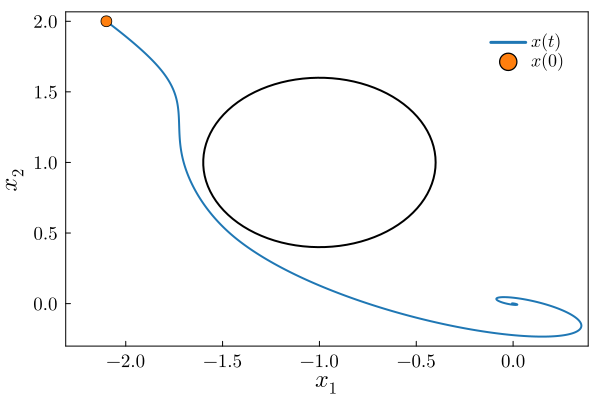

In [22]:
# Plot system trajectory
plot(sol, idxs=(1,2), xlabel=raw"$x_1$", ylabel=raw"$x_2$", label=raw"$x(t)$")
scatter!([x0[1]], [x0[2]], label=raw"$x(0)$", ms=6)
plot!(xo[1] .+ ro*cos.(LinRange(0, 2*π, 100)), xo[2] .+ ro*sin.(LinRange(0, 2*π, 100)), c=:black)

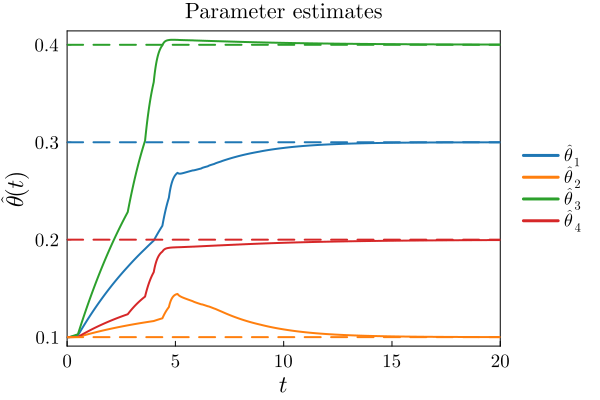

In [23]:
# Plot parameter estimates
plot(sol, idxs=5:8, xlabel=raw"$t$", ylabel=raw"$\hat{\theta}(t)$", label=[raw"$\hat{\theta}_1$" raw"$\hat{\theta}_2$" raw"$\hat{\theta}_3$" raw"$\hat{\theta}_4$"], title="Parameter estimates", legend_position=:outerright)
hline!([θ[1]], ls=:dash, c=1)
hline!([θ[2]], ls=:dash, c=2)
hline!([θ[3]], ls=:dash, c=3)
hline!([θ[4]], ls=:dash, c=4)

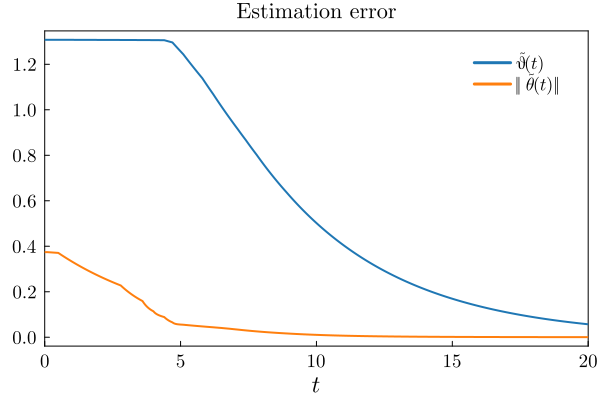

In [24]:
# Bounds on parameter estimation error
ts = 0.0:0.01:T
θ̃(t) = sol(t).x[2] - θ
plot(sol, idxs=9, xlabel=raw"$t$", title="Estimation error", label=raw"$\tilde{\vartheta}(t)$")
plot!(ts, norm.(θ̃.(ts)), label=raw"$\Vert \tilde{\theta}(t) \Vert$")